# cGAN para generación de ECG con BPM controlado (NeuroKit2 → TFLite)

**Objetivo:** generar señales ECG de ritmo sinusal normal condicionadas por BPM,
entrenar una cGAN compacta y convertir el generador a TensorFlow Lite (int8)
para inferencia en Arduino.


In [1]:
!nvidia-smi

Sat Dec 20 20:17:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.10              Driver Version: 581.29         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   48C    P8             10W /  160W |    1549MiB /   8188MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Instalación de dependencias

In [2]:
#!pip install neurokit2 tensorflow numpy scipy

## 2. Importaciones y parámetros globales

In [3]:
import numpy as np
import neurokit2 as nk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Parámetros - Múltiples latidos para apreciar visualmente BPM
FS = 360  # Hz
L = 1024  # 1024 muestras = 2.84 segundos (3-5 latidos para ver diferencias BPM)
Z_DIM = 32  # Más dimensión latente para riqueza
BPM_MIN = 40.0
BPM_MAX = 140.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Device: {device}")
print(f"✓ Frecuencia: {FS} Hz")
print(f"✓ Ventana: {L/FS:.2f} seg (múltiples latidos para ver BPM visualmente)")
print(f"✓ Latent dim: {Z_DIM}")


✓ Device: cuda
✓ Frecuencia: 360 Hz
✓ Ventana: 2.84 seg (múltiples latidos para ver BPM visualmente)
✓ Latent dim: 32


## 3. Generación de ECG sintético con NeuroKit2

In [4]:
def generate_ecg(bpm, duration=10):
    return nk.ecg_simulate(
        duration=duration,
        sampling_rate=FS,
        heart_rate=bpm,
        method='ecgsyn'
    )


## 4. Extracción de latidos alineados al pico R

In [5]:
def extract_windows(ecg, max_windows=None):
    """
    Extrae segmentos de L=1024 muestras (2.84s) conteniendo 3-5 latidos.
    Esto permite apreciar visualmente la diferencia de BPM en los gráficos.
    """
    signals, info = nk.ecg_process(ecg, sampling_rate=FS)
    rpeaks = info['ECG_R_Peaks']
    windows = []
    
    # Ventana grande: L//2 muestras antes del primer R, L//2 después del último
    pre = L // 2   
    post = L // 2  
    
    for r in rpeaks[::2]:  # Tomar cada 2do R-peak para reducir overlap
        if r - pre >= 0 and r + post <= len(ecg):
            window = ecg[r - pre:r + post]
            if len(window) == L and np.std(window) > 0.01:
                windows.append(window)
                if max_windows and len(windows) >= max_windows:
                    break
    
    return windows


## 5. Normalización de latidos (−1, 1)

In [6]:
def normalize_beat(x):
    x = x - np.mean(x)
    x = x / (np.std(x) + 1e-8)
    x = np.clip(x, -3, 3)
    return x / 3.0


## 6. Construcción del dataset (BPM 50–130)

In [7]:
X, Y = [], []

# Generar dataset con BPM PARES y exactamente 200 muestras por clase
print("="*80)
print("Generando dataset: BPM PARES con 200 señales por clase")
print("="*80)

TARGET_SAMPLES_PER_BPM = 200

for bpm in range(40, 141, 2):  # Solo BPM pares: 40, 42, 44, ..., 140
    print(f"Generando BPM={bpm:3d}: ", end='', flush=True)
    
    bpm_samples = []
    
    # Estrategia: generar suficientes muestras base (70-100) y luego augmentar
    base_samples_needed = 70  # Mínimo de muestras base antes de augmentar
    attempts = 0
    max_attempts = 8  # Reducir intentos, usaremos más augmentation
    
    while len(bpm_samples) < base_samples_needed and attempts < max_attempts:
        attempts += 1
        
        # Generar ECG de 40 segundos para obtener más ventanas
        ecg = generate_ecg(bpm, duration=40)
        windows = extract_windows(ecg, max_windows=base_samples_needed - len(bpm_samples))
        
        for w in windows:
            if len(bpm_samples) >= base_samples_needed:
                break
            
            # Normalizar y agregar
            w_normalized = normalize_beat(w)
            bpm_samples.append(w_normalized)
        
        print(f".", end='', flush=True)
    
    print(f" [{len(bpm_samples)}→200]", end='', flush=True)
    
    # Aplicar data augmentation para llegar a 200
    if len(bpm_samples) < TARGET_SAMPLES_PER_BPM:
        original_count = len(bpm_samples)
        
        while len(bpm_samples) < TARGET_SAMPLES_PER_BPM:
            # Seleccionar una muestra aleatoria existente
            idx = np.random.randint(0, original_count)
            signal = bpm_samples[idx]
            
            # Aplicar augmentation aleatorio
            aug_type = np.random.choice(['shift', 'noise', 'scale'])
            
            if aug_type == 'shift':
                # Rotación temporal
                shift = np.random.randint(-15, 16)
                augmented = np.roll(signal, shift, axis=0)
            elif aug_type == 'noise':
                # Ruido gaussiano
                augmented = signal + np.random.normal(0, 0.02, signal.shape)
            else:  # scale
                # Variación de amplitud
                scale = np.random.uniform(0.95, 1.05)
                augmented = signal * scale
            
            bpm_samples.append(augmented)
    
    # Tomar exactamente 200 muestras
    bpm_samples = bpm_samples[:TARGET_SAMPLES_PER_BPM]
    
    # Agregar al dataset
    X.extend(bpm_samples)
    Y.extend([bpm] * TARGET_SAMPLES_PER_BPM)
    
    print(f" ✓ {len(bpm_samples)} muestras")

# Reshape: [N, 1, L, 1] para PyTorch
X = np.array(X, dtype=np.float32).reshape(-1, L)
X = np.expand_dims(X, axis=(1, 3))  # [N, 1, L, 1]

Y = np.array(Y, dtype=np.float32)
Y_norm = ((Y - BPM_MIN) / (BPM_MAX - BPM_MIN)).reshape(-1, 1)

print("\n" + "="*80)
print("✓ Dataset CONSTRUIDO")
print("="*80)
print(f"  X shape: {X.shape}")
print(f"  Y shape: {Y_norm.shape}")
print(f"  Duración por ventana: {L/FS:.2f} segundos")
print(f"  BPM range: {int(Y.min())} - {int(Y.max())}")
print(f"  Clases BPM (pares): {len(np.unique(Y))}")
print(f"  Muestras por BPM: {TARGET_SAMPLES_PER_BPM}")
print(f"  Total de muestras: {X.shape[0]}")
print("="*80)


Generando dataset: BPM PARES con 200 señales por clase
Generando BPM= 40: ...... [70→200] ✓ 200 muestras
Generando BPM= 42: ...... [70→200] ✓ 200 muestras
Generando BPM= 44: ...... [70→200] ✓ 200 muestras
Generando BPM= 46: ..... [70→200] ✓ 200 muestras
Generando BPM= 48: ..... [70→200] ✓ 200 muestras
Generando BPM= 50: ..... [70→200] ✓ 200 muestras
Generando BPM= 52: ..... [70→200] ✓ 200 muestras
Generando BPM= 54: ..... [70→200] ✓ 200 muestras
Generando BPM= 56: ..... [70→200] ✓ 200 muestras
Generando BPM= 58: .... [70→200] ✓ 200 muestras
Generando BPM= 60: .... [70→200] ✓ 200 muestras
Generando BPM= 62: .... [70→200] ✓ 200 muestras
Generando BPM= 64: .... [70→200] ✓ 200 muestras
Generando BPM= 66: .... [70→200] ✓ 200 muestras
Generando BPM= 68: .... [70→200] ✓ 200 muestras
Generando BPM= 70: .... [70→200] ✓ 200 muestras
Generando BPM= 72: .... [70→200] ✓ 200 muestras
Generando BPM= 74: .... [70→200] ✓ 200 muestras
Generando BPM= 76: .... [70→200] ✓ 200 muestras
Generando BPM= 78: ..

In [20]:
import matplotlib.pyplot as plt

X.shape

(10200, 1, 1024, 1)

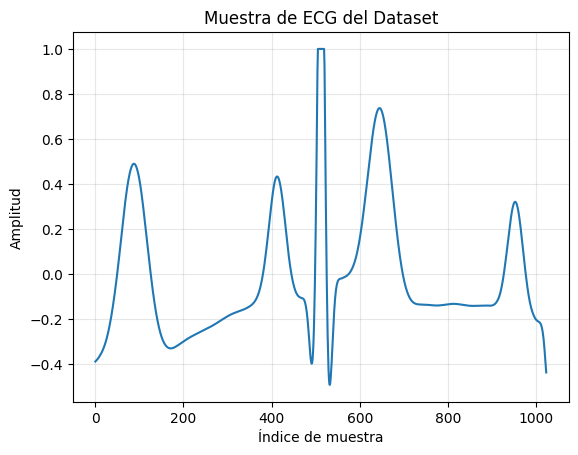

In [21]:
plt.plot(X[0].squeeze())
plt.title('Muestra de ECG del Dataset')
plt.xlabel('Índice de muestra')
plt.ylabel('Amplitud')
plt.grid(True, alpha=0.3)
plt.show()

Dataset size: 10200 latidos


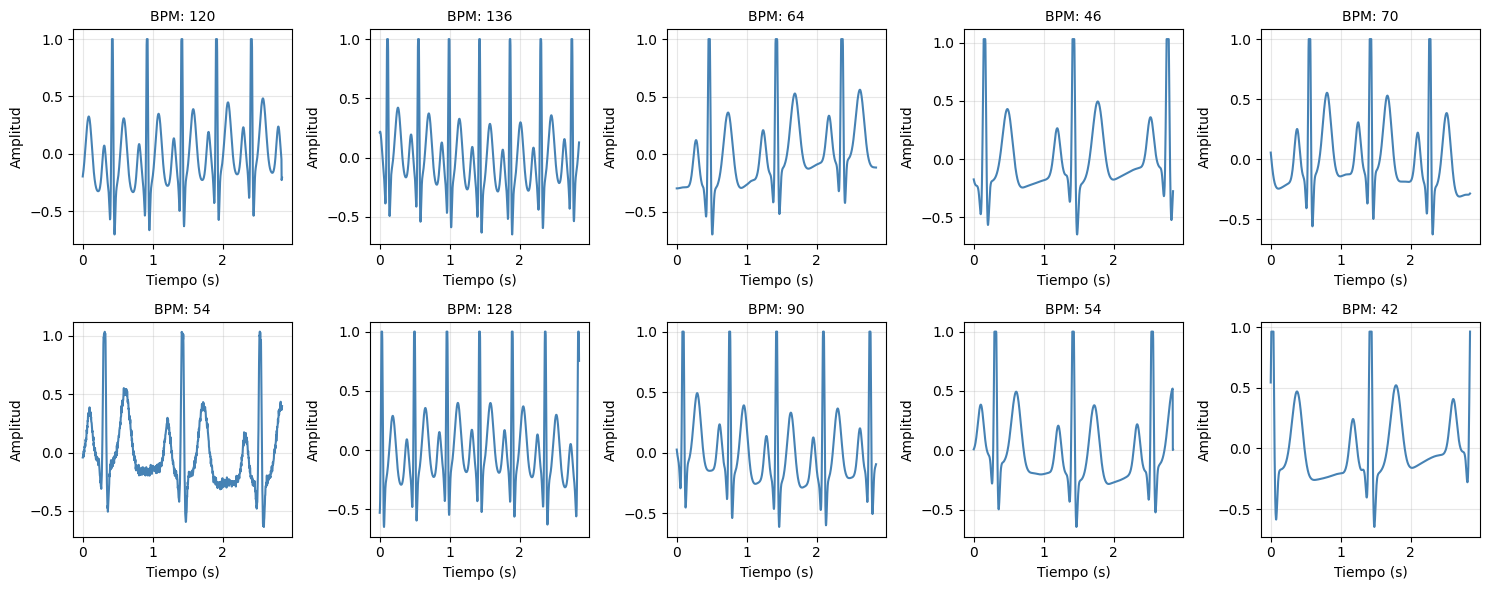

In [22]:
import matplotlib.pyplot as plt

print(f"Dataset size: {X.shape[0]} latidos")

# Seleccionar 10 índices aleatorios
num_samples = min(10, X.shape[0])
indices = np.random.choice(X.shape[0], num_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Eje X en tiempo (segundos)
time_axis = np.linspace(0, L/FS, L)

for i, idx in enumerate(indices):
    signal = X[idx].squeeze()
    bpm = Y[idx]
    axes[i].plot(time_axis, signal, linewidth=1.5, color='steelblue')
    axes[i].set_title(f'BPM: {int(bpm)}', fontsize=10)
    axes[i].set_xlabel('Tiempo (s)')
    axes[i].set_ylabel('Amplitud')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:
# Guardar dataset en disco para uso posterior
np.savez_compressed('ecg_cwgan_dataset_optimized.npz', X=X, Y=Y_norm)
print("✓ Dataset guardado en 'ecg_cwgan_dataset_optimized.npz'")



✓ Dataset guardado en 'ecg_cwgan_dataset_optimized.npz'


In [24]:
# abrir archivo guardado
data = np.load('ecg_cwgan_dataset_optimized.npz')
X_loaded = data['X']
Y_loaded = data['Y']
print(f"✓ Dataset cargado: X shape: {X_loaded.shape}, Y shape: {Y_loaded.shape}")


✓ Dataset cargado: X shape: (10200, 1, 1024, 1), Y shape: (10200, 1)


BPM original de la muestra cargada: 40.00


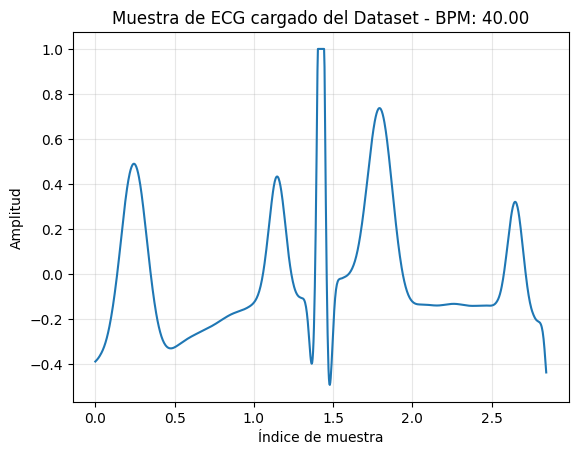

In [25]:
# graficar una muestra para verificar y como legenda su bpm original
bpm_original = Y_loaded[0] * (BPM_MAX - BPM_MIN) + BPM_MIN
print(f"BPM original de la muestra cargada: {bpm_original[0]:.2f}")
plt.plot(time_axis, X_loaded[0].squeeze())
plt.title(f'Muestra de ECG cargado del Dataset - BPM: {bpm_original[0]:.2f}')
plt.xlabel('Índice de muestra')
plt.ylabel('Amplitud')
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
# listame todos los bpm unicos en el dataset cargado
bpm_unicos = np.unique(Y_loaded * (BPM_MAX - BPM_MIN) + BPM_MIN)
print("BPM únicos en el dataset cargado:")
print(bpm_unicos)

BPM únicos en el dataset cargado:
[ 40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.  62.  64.  66.
  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.  90.  92.  94.
  96.  98. 100. 102. 104. 106. 108. 110. 112. 114. 116. 118. 120. 122.
 124. 126. 128. 130. 132. 134. 136. 138. 140.]


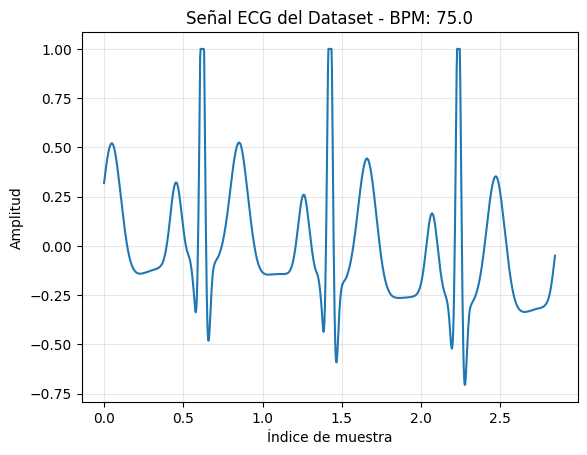

In [28]:
# graficar señal del dataset guardado a partir de su bpm
bpm_to_plot = 75.0  # Ejemplo de BPM a graficar
bpm_norm = (bpm_to_plot - BPM_MIN) / (BPM_MAX - BPM_MIN)

indices = np.where(np.isclose(Y_loaded.flatten(), bpm_norm, atol=0.01))[0]
if len(indices) > 0:
    idx = indices[0]
    plt.plot(time_axis, X_loaded[idx].squeeze())
    plt.title(f'Señal ECG del Dataset - BPM: {bpm_to_plot}')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Amplitud')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"No se encontró ninguna señal con BPM cercano a {bpm_to_plot}.")


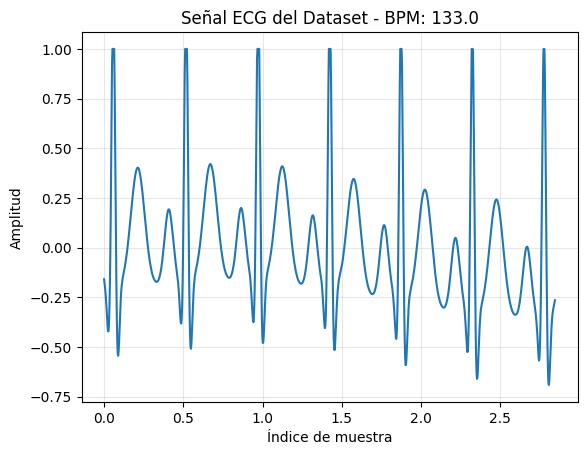

In [30]:
# graficar señal del dataset guardado a partir de su bpm
bpm_to_plot = 133.0  # Ejemplo de BPM a graficar
bpm_norm = (bpm_to_plot - BPM_MIN) / (BPM_MAX - BPM_MIN)

indices = np.where(np.isclose(Y_loaded.flatten(), bpm_norm, atol=0.01))[0]
if len(indices) > 0:
    idx = indices[0]
    plt.plot(time_axis, X_loaded[idx].squeeze())
    plt.title(f'Señal ECG del Dataset - BPM: {bpm_to_plot}')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Amplitud')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"No se encontró ninguna señal con BPM cercano a {bpm_to_plot}.")


In [61]:
# muestra el dataset en formato dataframe pandas con columnas expandidas
import pandas as pd

# Crear DataFrame con cada muestra de la señal ECG en su propia columna
ecg_signals = [X_loaded[i].squeeze() for i in range(X_loaded.shape[0])]
bpm_values = [int(Y_loaded[i][0] * (BPM_MAX - BPM_MIN) + BPM_MIN) for i in range(Y_loaded.shape[0])]

# Crear diccionario con columnas para cada muestra
data_dict = {}
for j in range(L):  # L = 1024 muestras
    data_dict[f'Sample_{j}'] = [signal[j] for signal in ecg_signals]

# Agregar columna BPM
data_dict['BPM'] = bpm_values

df = pd.DataFrame(data_dict)

print(f"DataFrame shape: {df.shape}")
print(f"Columnas: {df.shape[1]} ({L} muestras + 1 BPM)")
print(f"\nPrimeras 5 filas y primeras 10 columnas + BPM:")
print(df.iloc[:5, list(range(10)) + [-1]])

DataFrame shape: (10200, 1025)
Columnas: 1025 (1024 muestras + 1 BPM)

Primeras 5 filas y primeras 10 columnas + BPM:
   Sample_0  Sample_1  Sample_2  Sample_3  Sample_4  Sample_5  Sample_6  \
0 -0.389717 -0.387806 -0.385801 -0.383686 -0.381450 -0.379080 -0.376567   
1 -0.307445 -0.304545 -0.302119 -0.300017 -0.298258 -0.296770 -0.295484   
2  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  0.920649   
3 -0.517077 -0.499789 -0.472902 -0.438648 -0.399193 -0.356637 -0.313017   
4 -0.317218 -0.312633 -0.308797 -0.305470 -0.302690 -0.300343 -0.298325   

   Sample_7  Sample_8  Sample_9  BPM  
0 -0.373906 -0.371091 -0.368120   40  
1 -0.294340 -0.293282 -0.292262   40  
2  0.725705  0.536216  0.357121   40  
3 -0.270300 -0.230393 -0.195134   40  
4 -0.296543 -0.294917 -0.293375   40  


In [62]:
df

,Sample_0,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,...,Sample_1015,Sample_1016,Sample_1017,Sample_1018,Sample_1019,Sample_1020,Sample_1021,Sample_1022,Sample_1023,BPM
0,-0.389717,-0.387806,-0.385801,-0.383686,-0.381450,-0.379080,-0.376567,-0.373906,-0.371091,-0.368120,...,-0.258762,-0.272883,-0.290049,-0.310218,-0.333112,-0.358223,-0.384817,-0.411931,-0.438371,40
1,-0.307445,-0.304545,-0.302119,-0.300017,-0.298258,-0.296770,-0.295484,-0.294340,-0.293282,-0.292262,...,-0.263774,-0.217213,-0.150802,-0.063528,0.044899,0.174043,0.322746,0.489124,0.670570,40
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.920649,0.725705,0.536216,0.357121,...,-0.036666,-0.042890,-0.048524,-0.053589,-0.058106,-0.062097,-0.065588,-0.068606,-0.071179,40
3,-0.517077,-0.499789,-0.472902,-0.438648,-0.399193,-0.356637,-0.313017,-0.270300,-0.230393,-0.195134,...,-0.240214,-0.244605,-0.248305,-0.251334,-0.253722,-0.255511,-0.256753,-0.257512,-0.257863,40
4,-0.317218,-0.312633,-0.308797,-0.305470,-0.302690,-0.300343,-0.298325,-0.296543,-0.294917,-0.293375,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.902327,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,-0.028086,-0.006290,0.013456,0.030666,0.044926,0.055887,0.063271,0.066867,0.066533,0.062194,...,0.065296,0.087371,0.108761,0.129249,0.148617,0.166640,0.183093,0.197747,0.210369,140
10196,0.148962,0.171069,0.192077,0.211685,0.229625,-0.080874,-0.056830,-0.034330,-0.013906,0.003958,...,-0.062236,-0.040118,-0.017261,0.006191,0.030077,0.054216,0.078404,0.102421,0.126025,140
10197,0.353549,-0.036988,-0.016244,0.006297,0.030052,0.054432,0.078863,0.102776,0.125619,0.146846,...,0.177984,0.201520,0.224615,0.247026,0.268495,0.288751,0.307633,0.324902,0.340285,140
10198,-0.038847,-0.019905,0.000905,0.023456,0.047161,0.071422,0.095658,0.119309,0.141830,0.162700,...,0.272730,0.291976,0.309611,0.325404,0.339120,0.350569,0.359631,0.366186,0.370145,140


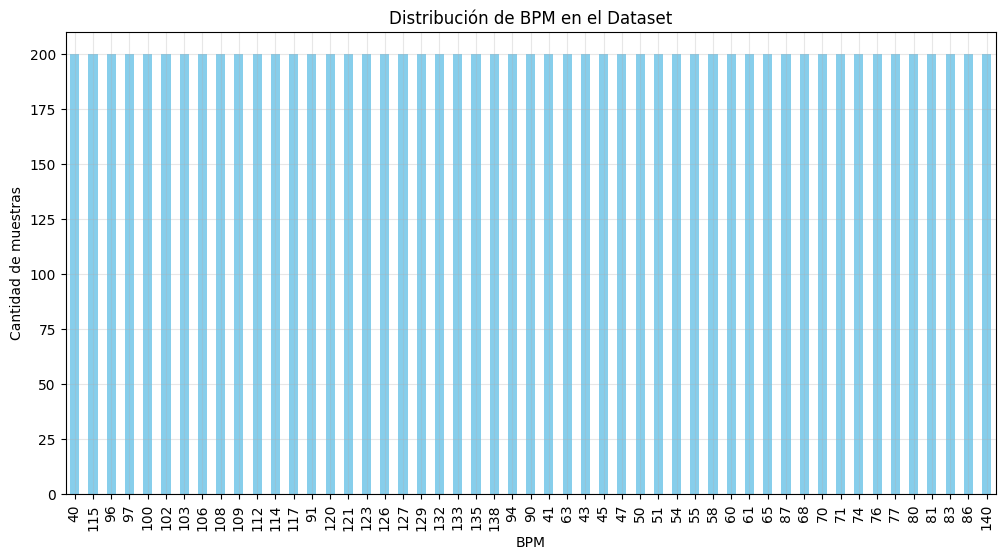

In [63]:
df.BPM.value_counts().plot(kind='bar', figsize=(12,6), color='skyblue')
plt.title('Distribución de BPM en el Dataset')
plt.xlabel('BPM')
plt.ylabel('Cantidad de muestras')
plt.grid(True, alpha=0.3)
plt.show()

In [64]:
# Guardar dataset en CSV con todas las columnas expandidas
print("Guardando dataset en CSV...")
df.to_csv("dataset_expanded.csv", index=False)
print(f"✓ Dataset guardado en 'dataset_expanded.csv'")
print(f"  Filas: {df.shape[0]}")
print(f"  Columnas: {df.shape[1]} (1024 muestras + BPM)")

Guardando dataset en CSV...
✓ Dataset guardado en 'dataset_expanded.csv'
  Filas: 10200
  Columnas: 1025 (1024 muestras + BPM)


In [66]:
# Cargar el dataset guardado para verificar
df2 = pd.read_csv("dataset_expanded.csv")
print(f"Dataset cargado: {df2.shape}")
print(f"\nPrimeras 3 filas, primeras 10 columnas + BPM:")
df2.iloc[:3, list(range(10)) + [-1]]

Dataset cargado: (10200, 1025)

Primeras 3 filas, primeras 10 columnas + BPM:


,Sample_0,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,BPM
0,-0.389717,-0.387806,-0.385801,-0.383686,-0.381450,-0.37908,-0.376567,-0.373906,-0.371091,-0.368120,40
1,-0.307445,-0.304545,-0.302119,-0.300017,-0.298258,-0.29677,-0.295484,-0.294339,-0.293282,-0.292262,40
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.920649,0.725705,0.536216,0.357121,40


BPM original de la muestra cargada: 43


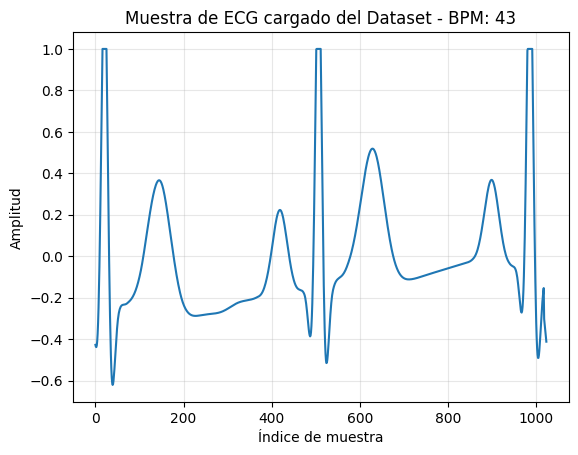

In [73]:
# graficar una muestra para verificar y como legenda su bpm original
bpm_original = df2['BPM'].iloc[500]
print(f"BPM original de la muestra cargada: {bpm_original}")
plt.plot(df2.iloc[500, :-1].values)
plt.title(f'Muestra de ECG cargado del Dataset - BPM: {bpm_original}')
plt.xlabel('Índice de muestra')
plt.ylabel('Amplitud')
plt.grid(True, alpha=0.3)
plt.show()